In [6]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from utils import configure_plot_style, set_size

PROJECT_ROOT = Path('..')
RESULTS_ROOT = PROJECT_ROOT / 'results'
GUROBI_RESULTS_ROOT = PROJECT_ROOT / 'benchmark' / 'gurobi_results'

configure_plot_style()

# AR vs $\chi$

/tmp/ipykernel_3078474/2468976515.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(CHI_VALUES)


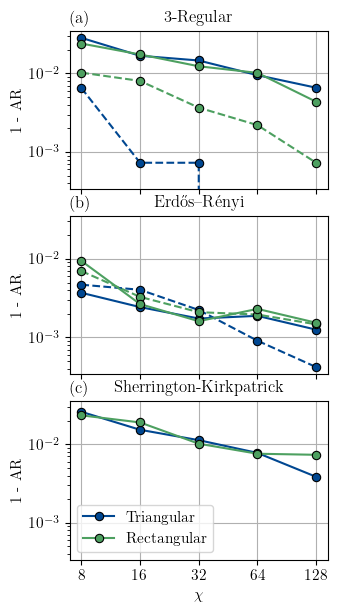

In [14]:
GRAPH_TYPES = ('MaxCut/3Reg', 'MaxCut/ER', 'MaxCut/SK')
ARCHITECTURES = ('triangular', 'quadratic')
ORDERINGS = ('fiedler', 'shuffle')
CHI_VALUES = [8, 16, 32, 64, 128]
N_VERTICES = 100
NUM_INSTANCES = 10
GRAPH_LABELS = {
    'MaxCut/3Reg': '3-Regular',
    'MaxCut/ER': 'Erdős–Rényi',
    'MaxCut/SK': 'Sherrington-Kirkpatrick',
}
GRAPH_SHORT_LABELS = {
    'MaxCut/3Reg': '3Reg',
    'MaxCut/ER': 'ER',
    'MaxCut/SK': 'SK',
}


def mps_results_path(graph_type, architecture, chi, ordering, instance, folder='MPS_final'):
    return (
        RESULTS_ROOT
        / graph_type
        / f"{N_VERTICES}v"
        / folder
        / f"ising_graph{instance}_{architecture}_chi{chi}_{ordering}"
        / 'results.h5'
    )


def load_energy_minima(graph_type, architecture, chi, ordering, folder='MPS_final'):
    minima = []
    for instance in range(NUM_INSTANCES):
        with h5py.File(mps_results_path(graph_type, architecture, chi, ordering, instance, folder), 'r') as data:
            minima.append(data['energy_samples'][:].min(axis=1))
    return pd.DataFrame(minima).T.ffill().cummin()


def load_gurobi_costs(graph_type):
    path = GUROBI_RESULTS_ROOT / graph_type / f"{N_VERTICES}v" / 'gurobi_costs.csv'
    return pd.read_csv(path).iloc[:NUM_INSTANCES]['cost'].values


def architecture_handles():
    return [
        Line2D([0], [0], color='C0', linestyle='-', marker='o', markeredgecolor='black', markeredgewidth=0.8, label='Triangular'),
        Line2D([0], [0], color='C1', linestyle='-', marker='o', markeredgecolor='black', markeredgewidth=0.8, label='Rectangular'),
    ]


color_map = {'triangular': 'C0', 'quadratic': 'C1'}
linestyle_map = {'fiedler': '--', 'shuffle': '-'}

fig, axes = plt.subplots(len(GRAPH_TYPES), 1, sharex=True, sharey=True)

for axis, graph_type in zip(axes, GRAPH_TYPES):
    gurobi_costs = load_gurobi_costs(graph_type)
    for architecture in ARCHITECTURES:
        for ordering in ORDERINGS:
            if ordering == 'fiedler' and graph_type.endswith('SK'):
                continue

            avg_gap = []
            for chi in CHI_VALUES:
                energy = load_energy_minima(graph_type, architecture, chi, ordering)
                final_ar = energy.div(gurobi_costs, axis=1).iloc[-1]
                avg_gap.append(1 - final_ar.mean())

            axis.semilogy(
                avg_gap,
                linestyle=linestyle_map[ordering],
                color=color_map[architecture],
                marker='o',
                markersize=6,
                markeredgecolor='black',
                markeredgewidth=0.8,
            )
    axis.grid(True)
    axis.set_title(GRAPH_LABELS[graph_type])

for idx, axis in enumerate(axes):
    axis.set_title(f"({chr(ord('a') + idx)})", loc='left')
    axis.set_ylabel('1 - AR')

axes[-1].set_xlabel(r"$\chi$")
axes[-1].set_xticklabels(CHI_VALUES)
axes[-1].set_xticks(range(len(CHI_VALUES)))
axes[-1].legend(handles=architecture_handles(), loc='lower left')

fig.set_size_inches(set_size(fraction=1, subplots=(3, 1)))
fig.set_dpi(100)
fig.tight_layout(pad=0.1)

fig.savefig('paper_figures/AR_architechture_MC.pdf', bbox_inches='tight')


# AR vs $\tau$

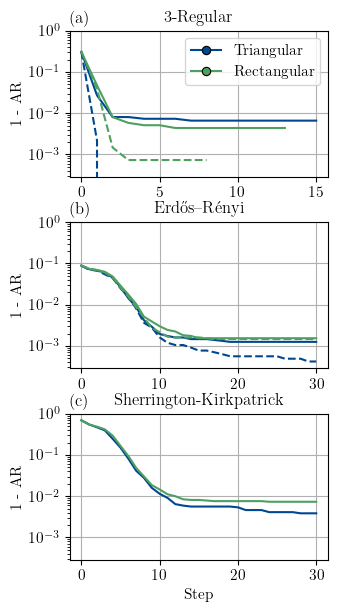

In [8]:
CHI_FIXED = 128

fig, axes = plt.subplots(len(GRAPH_TYPES), 1, sharex=False, sharey=True)

for axis, graph_type in zip(axes, GRAPH_TYPES):
    gurobi_costs = load_gurobi_costs(graph_type)
    for architecture in ARCHITECTURES:
        for ordering in ORDERINGS:
            if ordering == 'fiedler' and graph_type.endswith('SK'):
                continue

            energy = load_energy_minima(graph_type, architecture, CHI_FIXED, ordering)
            gap = 1 - energy.div(gurobi_costs, axis=1).mean(axis=1)

            axis.semilogy(
                gap.index,
                gap.values,
                linestyle=linestyle_map[ordering],
                color=color_map[architecture],
                markersize=5,
                markeredgecolor='black',
                markeredgewidth=0.8,
            )
    axis.grid(True)
    axis.set_title(GRAPH_LABELS[graph_type])

for idx, axis in enumerate(axes):
    axis.set_title(f"({chr(ord('a') + idx)})", loc='left')
    axis.set_ylabel('1 - AR')

axes[-1].set_xlabel('Step')
axes[0].legend(handles=architecture_handles(), loc='upper right')

fig.set_size_inches(set_size(fraction=1, subplots=(3, 1)))
fig.set_dpi(100)
fig.tight_layout(pad=0.1)

fig.savefig('paper_figures/AR_vs_tau.pdf', bbox_inches='tight')


# Runtime

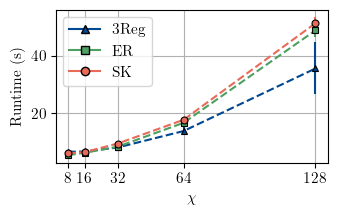

In [9]:
RUNTIME_INSTANCES = range(10, 20)
MARKER_MAP = {'MaxCut/3Reg': '^', 'MaxCut/ER': 's', 'MaxCut/SK': 'o'}
COLOR_MAP_RUNTIME = {'MaxCut/3Reg': 'C0', 'MaxCut/ER': 'C1', 'MaxCut/SK': 'C2'}


def load_runtime_deltas(graph_type, architecture, chi, ordering):
    deltas = []
    for instance in RUNTIME_INSTANCES:
        path = mps_results_path(graph_type, architecture, chi, ordering, instance)
        with h5py.File(path, 'r') as data:
            runtime = data['runtime'][:]
        step_durations = np.diff(runtime)
        if step_durations.size:
            deltas.append(step_durations.mean())
    return np.array(deltas)


fig, ax = plt.subplots()

for graph_type in GRAPH_TYPES:
    avg_runtime = []
    std_runtime = []
    for chi in CHI_VALUES:
        deltas = []
        for architecture in ARCHITECTURES:
            for ordering in ORDERINGS:
                if ordering == 'fiedler' and graph_type.endswith('SK'):
                    continue
                deltas.extend(load_runtime_deltas(graph_type, architecture, chi, ordering))
        deltas = np.array(deltas)
        avg_runtime.append(deltas.mean())
        std_runtime.append(deltas.std())

    ax.errorbar(
        CHI_VALUES,
        avg_runtime,
        yerr=std_runtime,
        marker=MARKER_MAP[graph_type],
        linestyle='--',
        markeredgecolor='black',
        markersize=5,
        markeredgewidth=0.8,
        color=COLOR_MAP_RUNTIME[graph_type],
        label=GRAPH_SHORT_LABELS[graph_type],
    )

legend_elements = [
    Line2D([0], [0], color='C0', linestyle='-', marker='^', markeredgecolor="black", label='3Reg'),
    Line2D([0], [0], color='C1', linestyle='-', marker='s', markeredgecolor="black", label='ER'),
    Line2D([0], [0], color='C2', linestyle='-', marker='o', markeredgecolor="black", label='SK')
]

ax.grid(True)
ax.set_xlabel(r"$\chi$")
ax.set_ylabel('Runtime (s)')
ax.set_xticks(CHI_VALUES)
ax.legend(handles=legend_elements, loc='upper left')

fig.set_size_inches(set_size(fraction=1, subplots=(1, 1)))
fig.set_dpi(100)
fig.tight_layout(pad=0.1)

fig.savefig('paper_figures/runtime_vs_chi.pdf', bbox_inches='tight')


# Distribution vs $\tau$

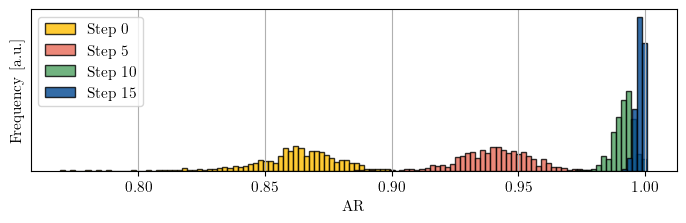

In [10]:
GRAPH_FOR_HIST = 'MaxCut/ER'
HIST_ARCHITECTURE = 'triangular'
HIST_ORDERING = 'shuffle'
HIST_INSTANCE = 0
HIST_CHI = 128
HIST_FOLDER = 'MPS_fix_dt'
STEPS_TO_PLOT = tuple(range(0, 17, 5))
BIN_WIDTH = 0.002

samples_path = mps_results_path(
    GRAPH_FOR_HIST,
    HIST_ARCHITECTURE,
    HIST_CHI,
    HIST_ORDERING,
    HIST_INSTANCE,
    folder=HIST_FOLDER,
)

gurobi_costs = load_gurobi_costs(GRAPH_FOR_HIST)
current_cost = gurobi_costs[HIST_INSTANCE]

with h5py.File(samples_path, 'r') as data:
    samples = data['energy_samples'][:] / current_cost

fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, step in enumerate(STEPS_TO_PLOT):
    series = samples[step, :]
    bins = np.arange(series.min(), series.max() + BIN_WIDTH, BIN_WIDTH)
    ax.hist(
        series,
        bins=bins,
        density=True,
        alpha=0.8,
        edgecolor='black',
        label=f'Step {step}',
        color=colors[::-1][idx % len(colors)],
    )

ax.set_xlabel('AR')
ax.set_ylabel('Frequency [a.u.]')
ax.set_yticks([])
ax.grid(True)
ax.legend()

fig.set_size_inches(set_size(width='full', fraction=1, subplots=(1, 1), squeeze_height=0.5))
fig.set_dpi(100)
fig.tight_layout(pad=0.1)

fig.savefig('paper_figures/energy_histogram.pdf', bbox_inches='tight')
